# Political Bias Detection in German News Articles

In [162]:
import tensorflow
from explore_data import*
from prepare_data import*
from classifiers.embedding import*
from classifiers.lstm import*
from classifiers.cnn import*
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Exploration

### GermaParl

In order to explore GermaParl download the dataset from [here](https://github.com/PolMine/GermaParlTEI).

In [2]:
germa_parl = GermaParl('GermaParlTEI')

### News Articles

Either download the the pickle files from [here](https://drive.google.com/file/d/13Kp7rEwMcM-1wb8usEjdnxbLGZPO3y2f/view?usp=sharing) or run ScrapeArchive.jf for scraping the archive of junge freiheit and so on. 

#### Junge Freiheit

In [3]:
jf = LoadArchive('NewsArchive/jungefreiheit_archive.pkl')

#### Jungle World

In [4]:
jw = LoadArchive('NewsArchive/jungleworld_archive.pkl')

#### Sueddeutsche Zeitung

In [5]:
sz = LoadArchive('NewsArchive/sueddeutsche_archive.pkl')

### Bringing everything together

In [6]:
data = germa_parl.texts + jf.texts + jw.texts + sz.texts
labels = germa_parl.labels + jf.labels + jw.labels + sz.labels

In [7]:
len(data)

444549

In [9]:
num_words_per_sample(data)

277.0

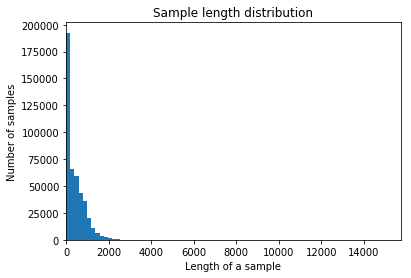

In [10]:
plot_sample_length_distribution(data)

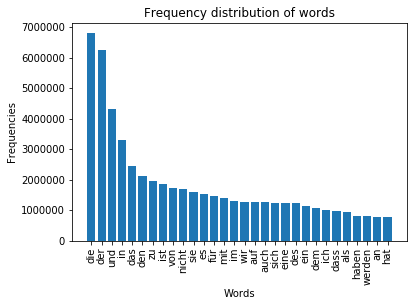

In [11]:
data_word_frequency = plot_word_frequency_distribution(data)

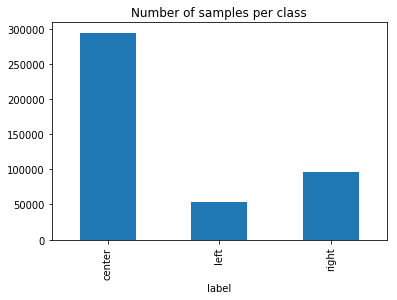

In [12]:
num_samples_per_class(labels)

## Data Preperation

Calculate the number of samples/number of words per sample ratio.

In [13]:
len(data)/num_words_per_sample(data)

1604.870036101083

Ratio is greater than 1500, we tokenize the text as sequences and use a pretrained fine-tuned pre-trained embedding. For this, download the vocabulary and vectors from [here](https://deepset.ai/german-word-embeddings) and place it in GloVe folder.

In [33]:
sequence_vectorize = SequenceVectorize(data, vocab=False)
vect_texts = sequence_vectorize.vectorize()

In [34]:
train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = train_val_test_split(vect_texts, 
                                                                                                 labels, 
                                                                                                 reproduceable=True)

/opt/anaconda/envs/playground/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Model Building

In [75]:
embedding_layer = get_embedding(sequence_vectorize.word_index, train_texts.shape[1], pretrained_embedding=True)

In [250]:
lstm = LongShortTermMemory(embedding_layer, train_labels.shape[1])
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-3)
model = lstm.stacked_lstm(opt, out_dim=32, dropout=0.2)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 300)          6000300   
_________________________________________________________________
lstm_52 (LSTM)               (None, 500, 256)          570368    
_________________________________________________________________
lstm_53 (LSTM)               (None, 500, 128)          197120    
_________________________________________________________________
lstm_54 (LSTM)               (None, 500, 64)           49408     
_________________________________________________________________
lstm_55 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 99        
Total params: 6,829,711
Trainable params: 829,411
Non-trainable params: 6,000,300
_____________________________________

## Training

In [251]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='models/lstm.{epoch:02d}-{val_loss:.2f}.h5'),
    tensorflow.keras.callbacks.TensorBoard(log_dir='models/./logs'),
]

In [ ]:
model.fit(train_texts, train_labels, validation_data=(val_texts, val_labels), 
          epochs=1000, batch_size=512, verbose=1, callbacks=my_callbacks)

Epoch 1/1000
695/695 [==============================] - 242s 349ms/step - loss: 0.6849 - accuracy: 0.6589 - val_loss: 0.6360 - val_accuracy: 0.6616
Epoch 2/1000
695/695 [==============================] - 241s 346ms/step - loss: 0.6360 - accuracy: 0.6626 - val_loss: 0.6187 - val_accuracy: 0.6635
Epoch 3/1000
394/695 [================>.............] - ETA: 1:37 - loss: 0.6203 - accuracy: 0.6666